In [85]:
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import mdtraj as md

In [86]:
pdb='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/PaaA2.pdb'
trajectory='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/PaaA2-a99SBdisp-Traj.dcd'
dihedraldir='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/dihedrals/'
if not os.path.exists(dihedraldir):
    os.makedirs(dihedraldir)
print("pdb:", pdb)
print("dihedraldir:", dihedraldir)
print("trajectory:", trajectory)

pdb: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/PaaA2.pdb
dihedraldir: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/dihedrals/
trajectory: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/PaaA2-a99SBdisp-Traj.dcd


In [87]:
stride_sel=1
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [88]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])




print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 1165

Number of residues: 71

Number of frames: 29977

Starting frame: 0

Last frame: 29977

sequence:  [MET1, ASP2, TYR3, LYS4, ASP5, ASP6, ASP7, ASP8, LYS9, ASN10, ARG11, ALA12, LEU13, SER14, PRO15, MET16, VAL17, SER18, GLU19, PHE20, GLU21, THR22, ILE23, GLU24, GLN25, GLU26, ASN27, SER28, TYR29, ASN30, GLU31, TRP32, LEU33, ARG34, ALA35, LYS36, VAL37, ALA38, THR39, SER40, LEU41, ALA42, ASP43, PRO44, ARG45, PRO46, ALA47, ILE48, PRO49, HIS50, ASP51, GLU52, VAL53, GLU54, ARG55, ARG56, MET57, ALA58, GLU59, ARG60, PHE61, ALA62, LYS63, MET64, ARG65, LYS66, GLU67, ARG68, SER69, LYS70, GLN71]

residue names:  ['MET', 'ASP', 'TYR', 'LYS', 'ASP', 'ASP', 'ASP', 'ASP', 'LYS', 'ASN', 'ARG', 'ALA', 'LEU', 'SER', 'PRO', 'MET', 'VAL', 'SER', 'GLU', 'PHE', 'GLU', 'THR', 'ILE', 'GLU', 'GLN', 'GLU', 'ASN', 'SER', 'TYR', 'ASN', 'GLU', 'TRP', 'LEU', 'ARG', 'ALA', 'LYS', 'VAL', 'ALA', 'THR', 'SER', 'LEU', 'ALA', 'ASP', 'PRO', 'ARG', 'PRO', 'ALA', 'ILE', 'PRO', 'HIS', 'AS

In [89]:
combined_weights = np.loadtxt('/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/Jan_2023_leave_one_out/CA-CB-HA-H-N-C-RDC-SAXS/weights_final.dat')

In [90]:
phipsi = np.stack([md.compute_phi(trj)[-1][1:],md.compute_psi(trj)[-1][1:]])

In [91]:
resnames = np.array([residue.name for residue in trj.topology.residues])

In [92]:
def plot_dihedral(data:"np.array with dimensions: (phi,psi),(N_frames),(N_residues-1)",
                  resnames:"3 letter strings of sequence", weights:"reweight data", 
                  residue:"residue type to plot", stride=1):
    idx_= np.where(resnames[1:-1]==residue)[0]
    for idx in idx_:
        fig, ax = plt.subplots(2, 2, figsize=((8,8)), sharex = True, sharey = True)
        hist_i=ax[0,0].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(), bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_r=ax[0,1].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(),weights=weights, bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_init=hist_i[0]/np.sum(hist_i[0])
        hist_re=hist_r[0]/np.sum(hist_r[0])
        xedges=hist_i[1]
        yedges=hist_i[2]
        hist_diff=hist_init - hist_re
        #hist_int - hist_re = hist_diff. For +hist_diff.T red is a descrease, blue is increase )
        ax[1,0].pcolorfast(xedges, yedges, hist_diff.T,cmap='seismic')
        # -hist_diff.T shows log plot of regions with an increase density, and regions with a decrease are blank
        ax[1,1].pcolorfast(xedges, yedges, -hist_diff.T,norm=colors.LogNorm(),cmap='jet')
        for axes in ax.flat:
            axes.set_xlabel(r"$\phi$", size = 20)
            axes.set_ylabel(r"$\psi$",size = 20)
        fig.suptitle(f"{residue}:{idx+2}", fontsize=20)


10
33
36
40
45
56
60


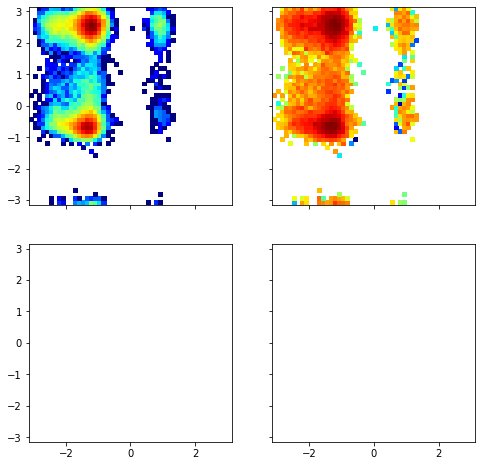

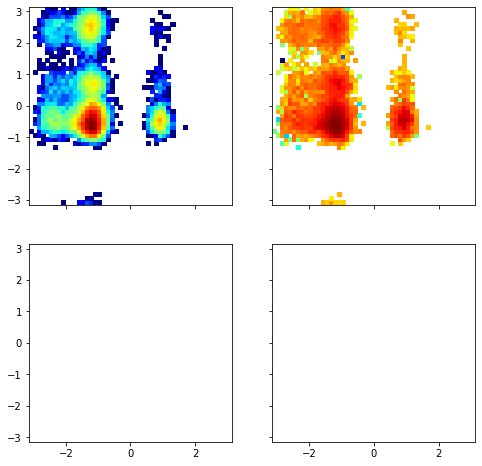

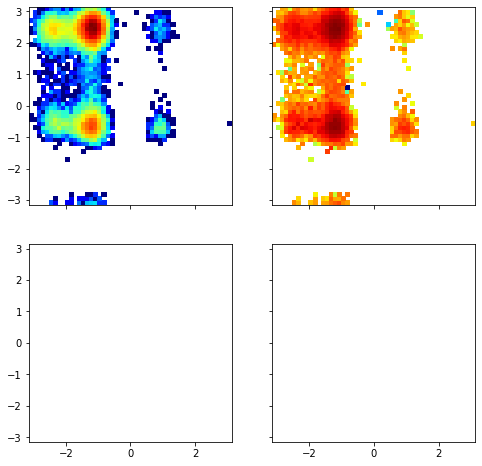

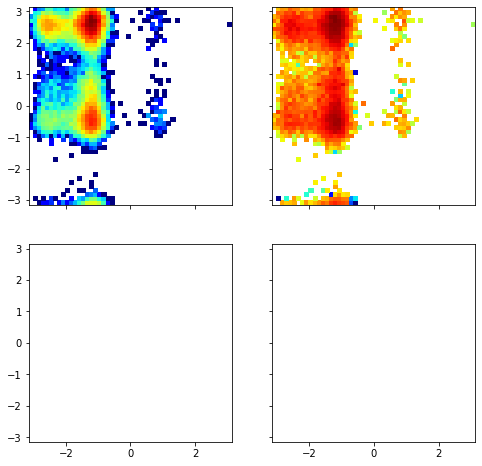

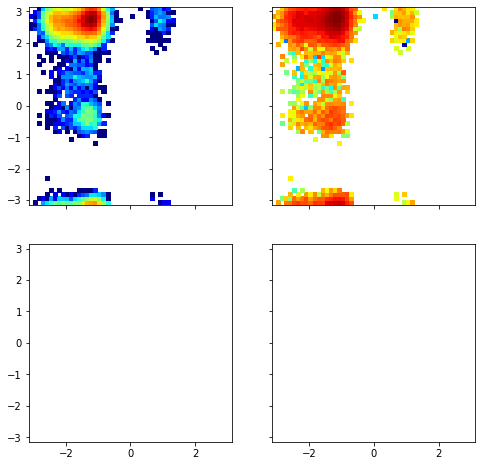

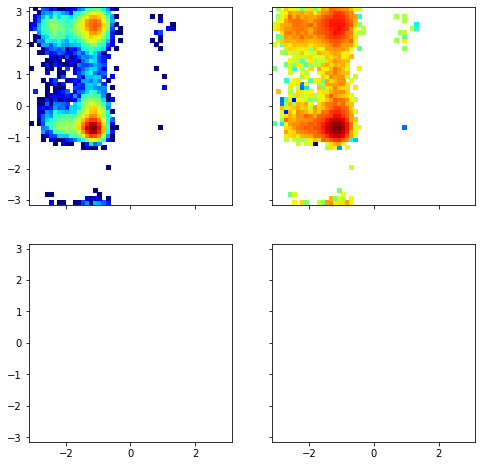

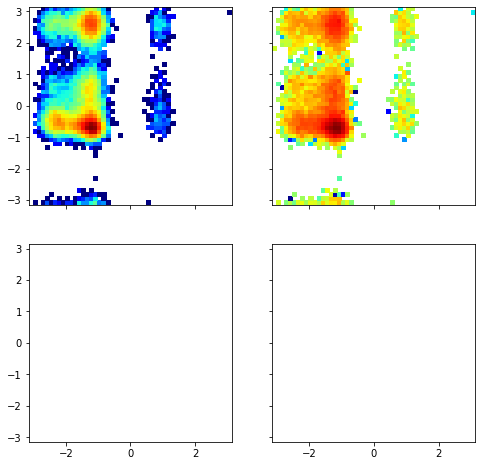

In [94]:
test=save_dihedrals(phipsi,resnames, combined_weights, "ALA")


In [95]:
n=0
hist=np.zeros((50,50))

for key in test:
    n+=1;
    hist+=test[key]['init']

print(n)
print(hist)
print(hist/n)

7
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.33671608e-04
  0.00000000e+00 0.00000000e+00]
 [6.67534587e-05 3.33778371e-05 0.00000000e+00 ... 6.00737606e-04
  5.00650875e-04 1.00116809e-04]
 [3.33778371e-05 3.33912114e-05 0.00000000e+00 ... 1.76879825e-03
  8.01012459e-04 2.67006005e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.33622473e-05 0.00000000e+00]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.33816583e-05
  0.00000000e+00 0.00000000e+00]
 [9.53620839e-06 4.76826245e-06 0.00000000e+00 ... 8.58196581e-05
  7.15215536e-05 1.43024012e-05]
 [4.76826245e-06 4.77017306e-06 0.00000000e+00 ... 2.52685464e-04
  1.14430351e-04 3.81437150e-05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+0

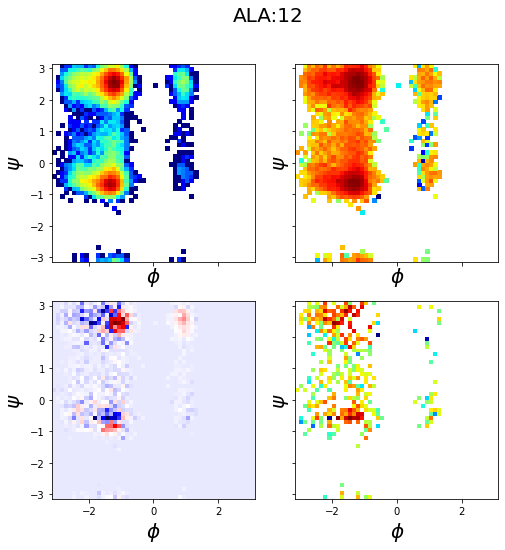

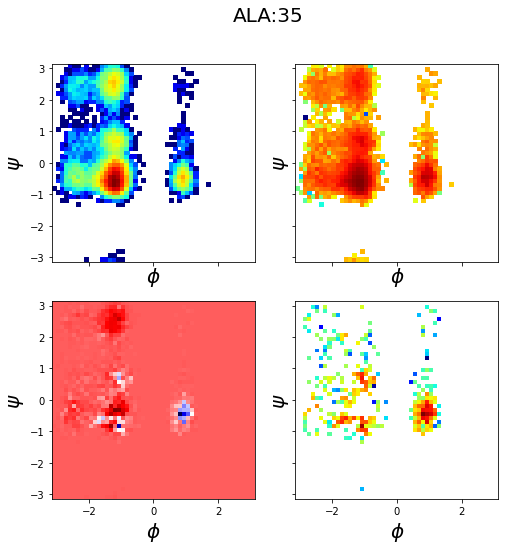

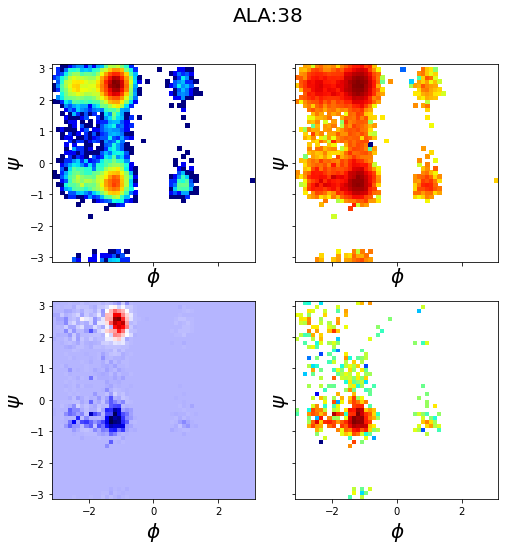

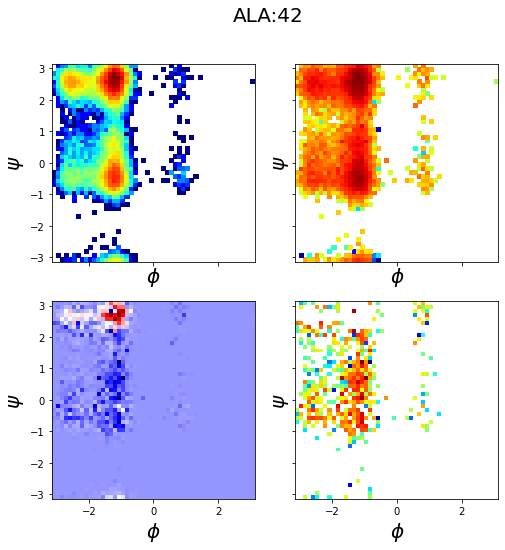

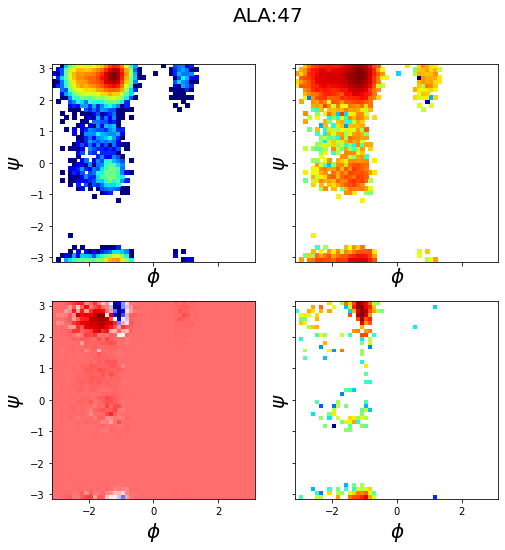

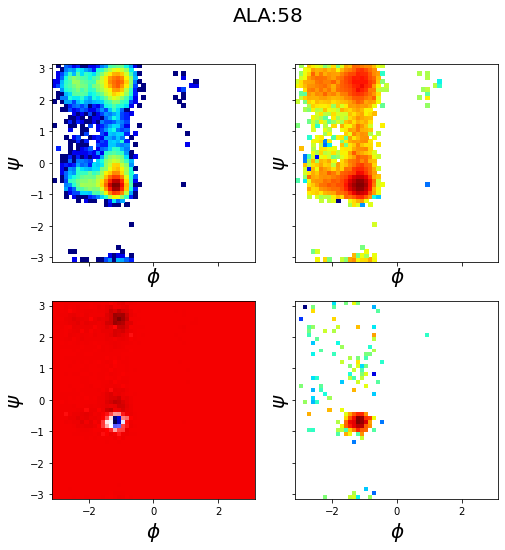

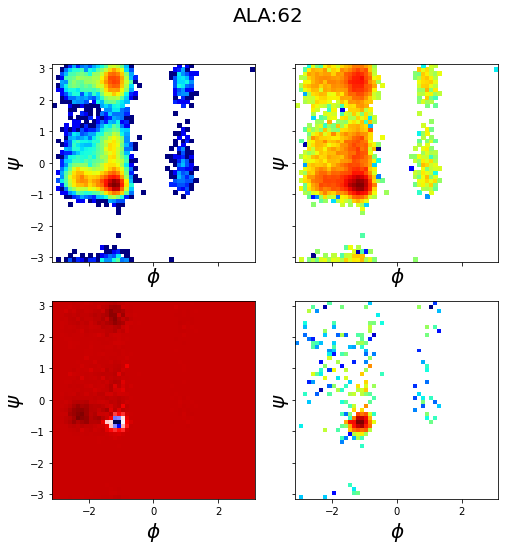

In [96]:
plot_dihedral(phipsi,resnames, combined_weights, "ALA")

In [97]:
test[10]['init']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.00173484e-04, 1.33448989e-04, 3.33622473e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

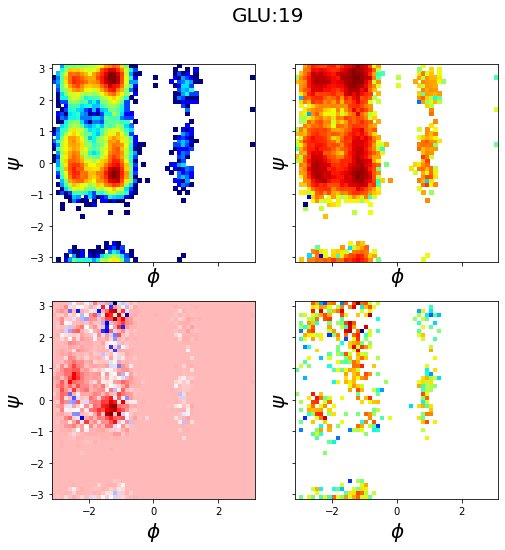

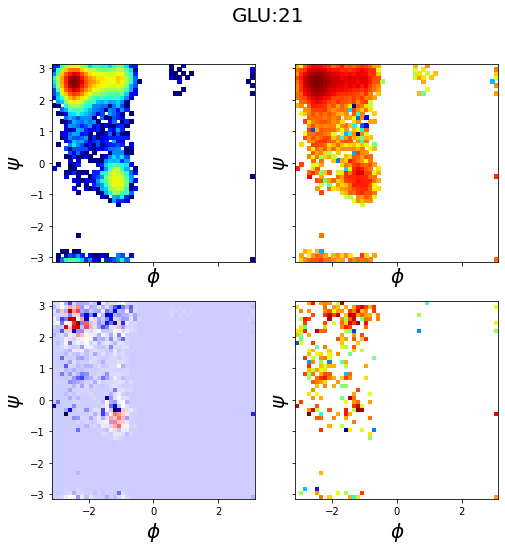

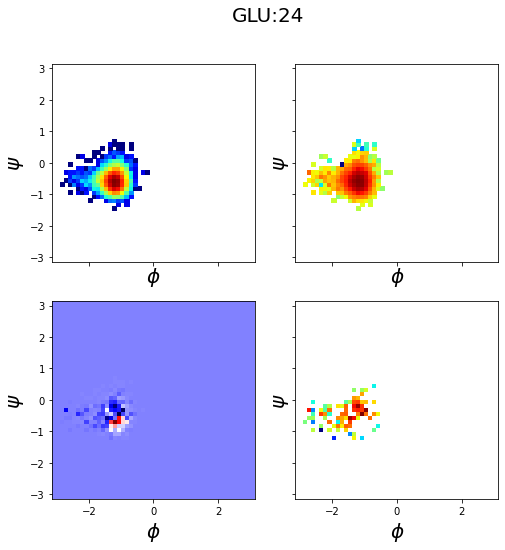

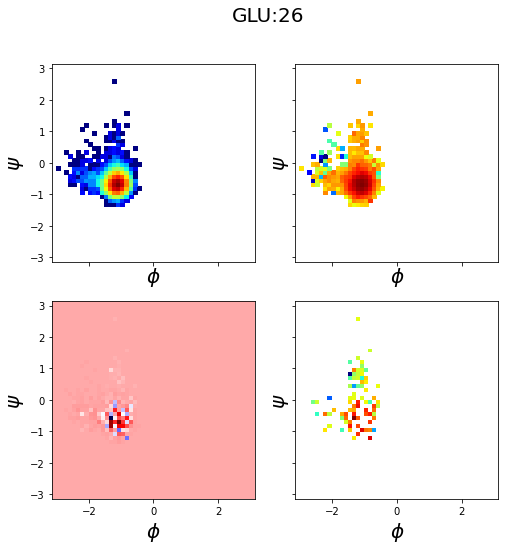

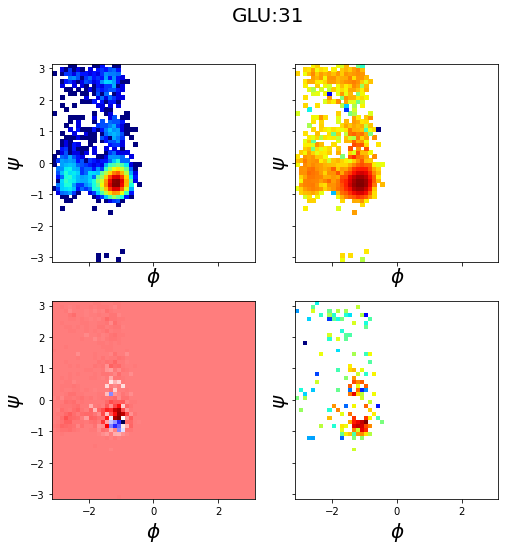

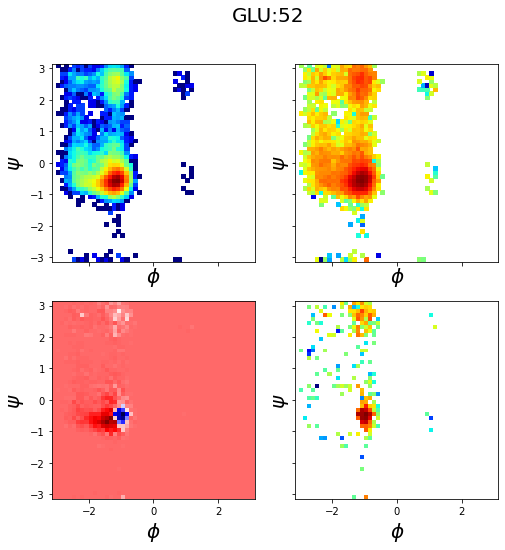

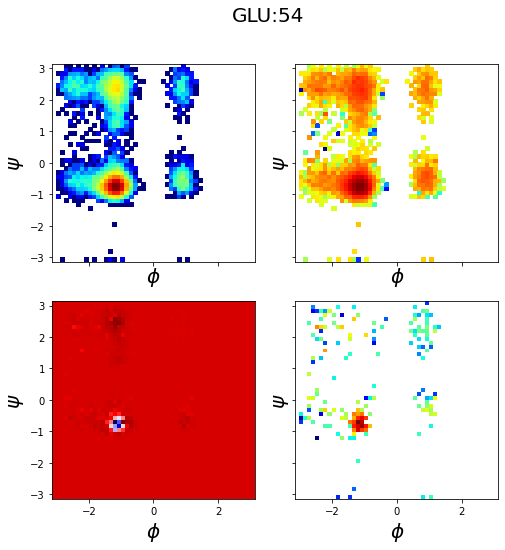

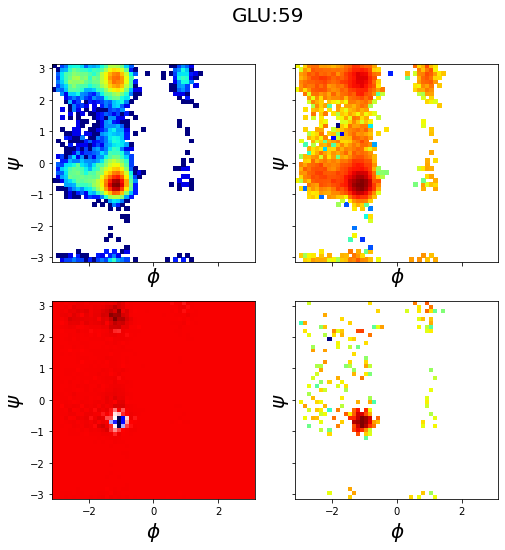

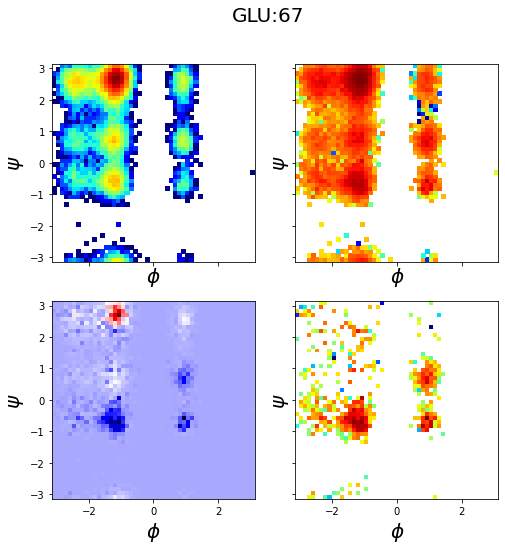

In [98]:
plot_dihedral(phipsi,resnames, combined_weights, "GLU")

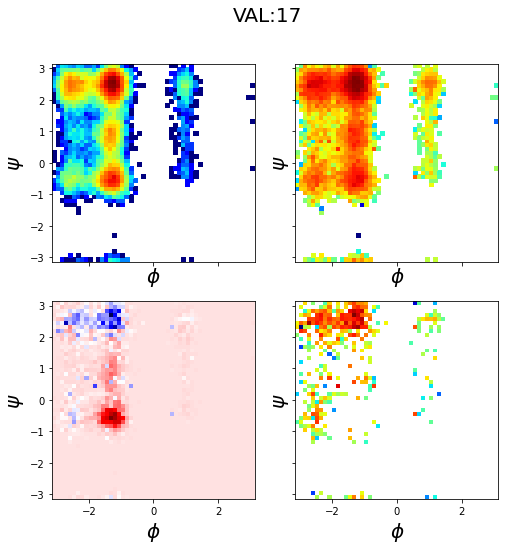

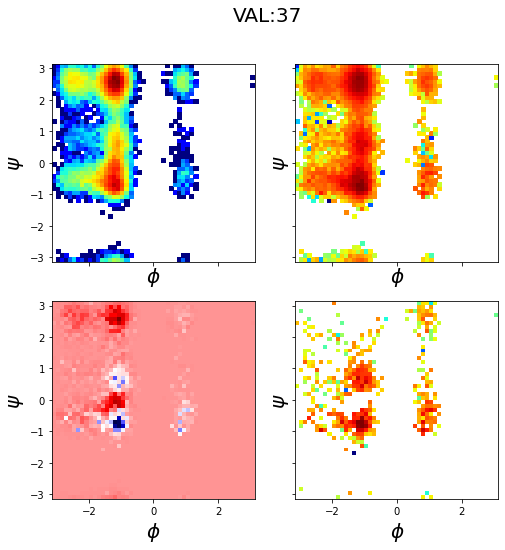

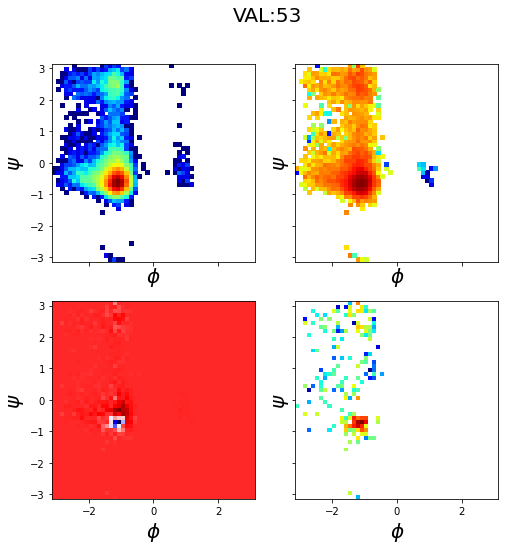

In [99]:
plot_dihedral(phipsi,resnames, combined_weights, "VAL")

In [100]:
def plot_dihedral_average(data:"np.array with dimensions: (phi,psi),(N_frames),(N_residues-1)",
                  resnames:"3 letter strings of sequence", weights:"reweight data", 
                  residue:"residue type to plot", stride=1):
    idx_= np.where(resnames[1:-1]==residue)[0]
    #print(idx_)
    #fig, ax = plt.subplots(2, 2, figsize=((8,8)), sharex = True, sharey = True)
    fig, ax = plt.subplots(2, 2, figsize=((8,8)), sharex = True, sharey = True)
    hist_i=ax[0,0].hist2d(data[0,::stride,idx_+1].mean(0).flatten(), data[-1,::stride,idx_].mean(0).flatten(), bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
    print((data[-1,::stride,idx_].mean(0).flatten().shape))
    hist_r=ax[0,1].hist2d(data[0,::stride,idx_+1].mean(0).flatten(), data[-1,::stride,idx_].mean(0).flatten(),weights=weights, bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
    print((data[-1,::stride,idx_].mean(0).flatten().shape))
    hist_init=hist_i[0]/np.sum(hist_i[0])
    hist_re=hist_r[0]/np.sum(hist_r[0])
    xedges=hist_i[1]
    yedges=hist_i[2]
    hist_diff=hist_init - hist_re
        #hist_int - hist_re = hist_diff. For +hist_diff.T red is a descrease, blue is increase )
    ax[1,0].pcolorfast(xedges, yedges, hist_diff.T,cmap='seismic')
        # -hist_diff.T shows log plot of regions with an increase density, and regions with a decrease are blank
    ax[1,1].pcolorfast(xedges, yedges, -hist_diff.T,norm=colors.LogNorm(),cmap='jet')
    for axes in ax.flat:
        axes.set_xlabel(r"$\phi$", size = 20)
        axes.set_ylabel(r"$\psi$",size = 20)

(29976,)
(29976,)


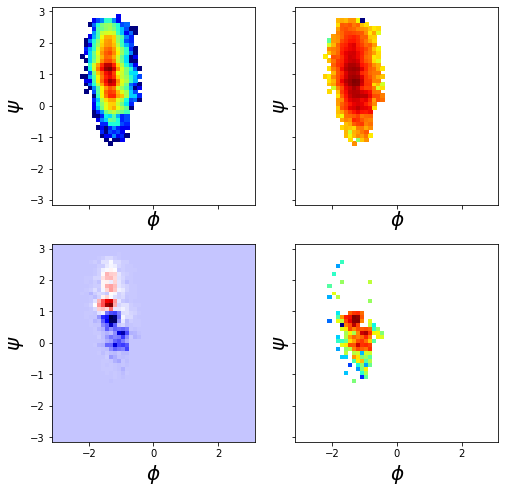

In [101]:
plot_dihedral_average(phipsi,resnames, combined_weights, 'ALA')

In [106]:
def save_dihedrals(data:"np.array with dimensions: (phi,psi),(N_frames),(N_residues-1)",
                  resnames:"3 letter strings of sequence", weights:"reweight data", 
                  residue:"residue type to plot",stride=1):
    idx_= np.where(resnames[1:-1]==residue)[0]
    out_dictionary={}
    for idx in idx_:
        print(idx)
        out_dictionary[idx]={}
        fig, ax = plt.subplots(2, 2, figsize=((8,8)), sharex = True, sharey = True)
        hist_i=ax[0,0].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(), bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_r=ax[0,1].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(),weights=weights, bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_init=hist_i[0]/np.sum(hist_i[0])
        hist_re=hist_r[0]/np.sum(hist_r[0])
        xedges=hist_i[1]
        yedges=hist_i[2]
        hist_diff=hist_init - hist_re
        out_dictionary[idx]['init']=hist_init
        out_dictionary[idx]['reweight']=hist_re
        out_dictionary[idx]['diff']=hist_diff
    return out_dictionary

10
33
36
40
45
56
60


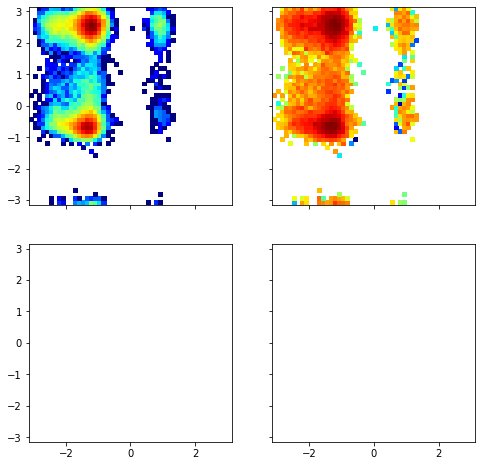

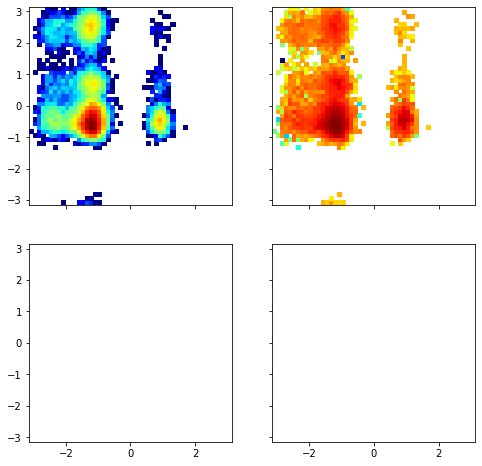

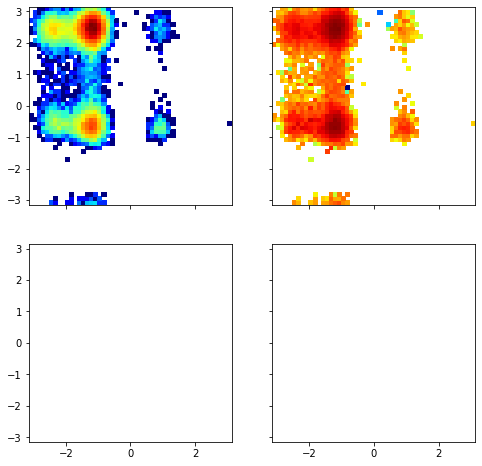

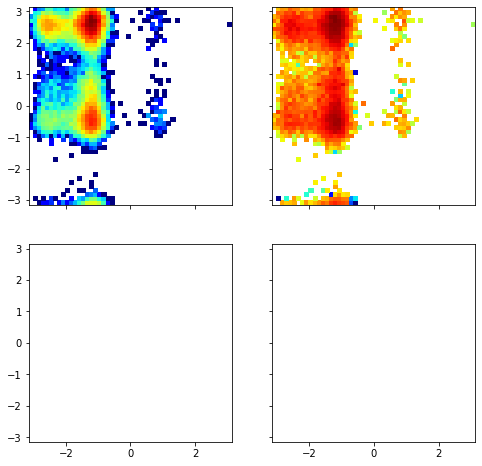

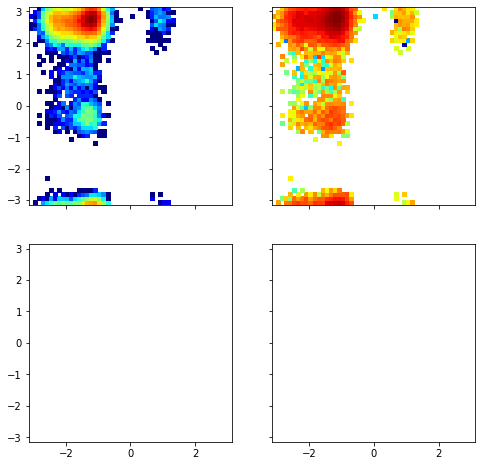

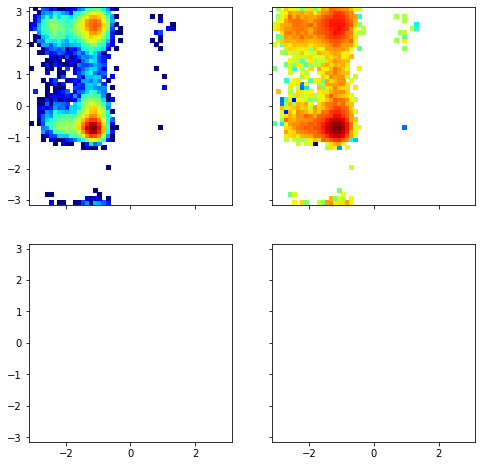

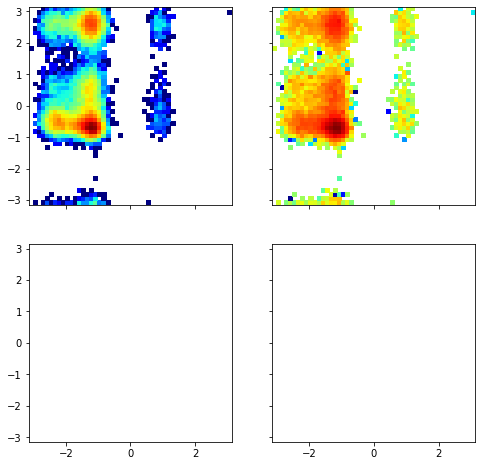

In [107]:
test=save_dihedrals(phipsi,resnames, combined_weights, "ALA")

In [108]:
n=0
hist=np.zeros((50,50))

for key in test:
    n+=1;
    hist+=test[key]['init']

print(n)
print(hist)
print(hist/n)

7
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.33671608e-04
  0.00000000e+00 0.00000000e+00]
 [6.67534587e-05 3.33778371e-05 0.00000000e+00 ... 6.00737606e-04
  5.00650875e-04 1.00116809e-04]
 [3.33778371e-05 3.33912114e-05 0.00000000e+00 ... 1.76879825e-03
  8.01012459e-04 2.67006005e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.33622473e-05 0.00000000e+00]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.33816583e-05
  0.00000000e+00 0.00000000e+00]
 [9.53620839e-06 4.76826245e-06 0.00000000e+00 ... 8.58196581e-05
  7.15215536e-05 1.43024012e-05]
 [4.76826245e-06 4.77017306e-06 0.00000000e+00 ... 2.52685464e-04
  1.14430351e-04 3.81437150e-05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+0

In [104]:
test.keys()

dict_keys([10, 33, 36, 40, 45, 56, 60])

In [103]:
sequence

' [MET1, ASP2, TYR3, LYS4, ASP5, ASP6, ASP7, ASP8, LYS9, ASN10, ARG11, ALA12, LEU13, SER14, PRO15, MET16, VAL17, SER18, GLU19, PHE20, GLU21, THR22, ILE23, GLU24, GLN25, GLU26, ASN27, SER28, TYR29, ASN30, GLU31, TRP32, LEU33, ARG34, ALA35, LYS36, VAL37, ALA38, THR39, SER40, LEU41, ALA42, ASP43, PRO44, ARG45, PRO46, ALA47, ILE48, PRO49, HIS50, ASP51, GLU52, VAL53, GLU54, ARG55, ARG56, MET57, ALA58, GLU59, ARG60, PHE61, ALA62, LYS63, MET64, ARG65, LYS66, GLU67, ARG68, SER69, LYS70, GLN71]'

In [105]:
test

{10: {'init': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.00173484e-04, 1.33448989e-04, 3.33622473e-05],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  'reweight': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0